In [45]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [46]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## We will introduce linear regressiong first using very fundamental methods using 
    from sklearn.preprocessing import PolynomialFeatures

## Then do a multifeature linear regression with Theano

#### Data
1. $x$ portion of religious people in a county 
1. $y$ be the probability of voting for Rom
1. $y$ should be written as a function of $x$-- we want to predict $y$


In [47]:
dffull=pd.read_csv("religion.csv")
dffull.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


### In an IDEAL world, you will see some smooth "fit" as the following by some god giving function. But in reality, you will see noisy data

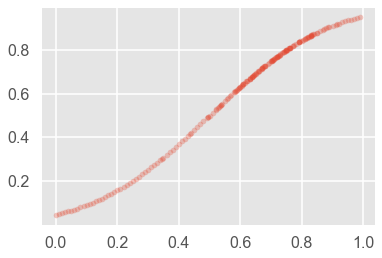

In [48]:
## all data without noise
x = dffull.rfrac.values
f = dffull.promney.values
plt.style.use(style='ggplot')
plt.plot(x,f,'.', alpha=0.3)

In [49]:
df = pd.read_csv("noisysample.csv")
df.head()

,f,i,x,y
0,0.075881,7,0.07,0.138973
1,0.085865,9,0.09,0.050510
2,0.096800,11,0.11,0.183821
3,0.184060,23,0.23,0.057621
4,0.285470,33,0.33,0.358174


Now, in real life we are only given a sample of points. Lets assume that out of this population of 200 points we are given a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, the entire population of data points is also called **out-of-sample data**.

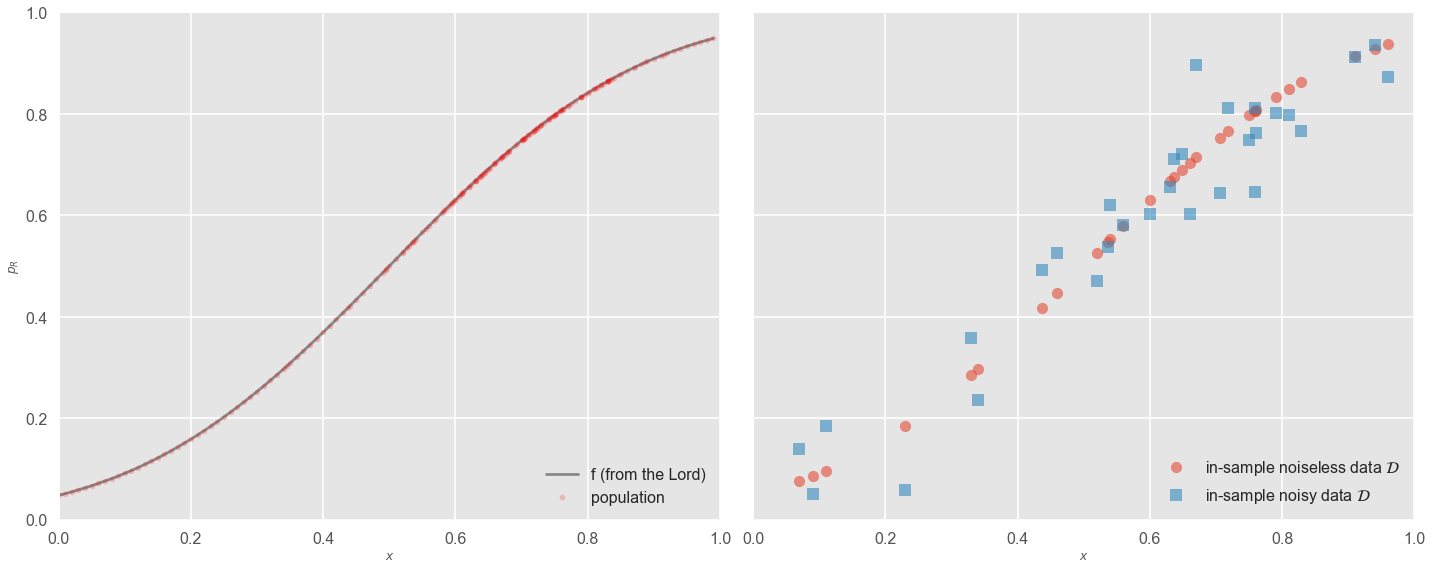

In [50]:
## NOTE: y stands for noisy data for x
axes=make_plot()
axes[0].plot(x,f, 'k-', alpha=0.4, label="f (from the Lord)");
axes[0].plot(x,f, 'r.', alpha=0.2, label="population");
axes[1].plot(df.x,df.f, 'o', alpha=0.6, \
             label="in-sample noiseless data $\cal{D}$");
axes[1].plot(df.x,df.y, 's', alpha=0.6, \
             label="in-sample noisy data $\cal{D}$");
axes[0].legend(loc=4);
axes[1].legend(loc=4);

### Mathematically, we are trying to solve:
$$
\begin{eqnarray*}
A &:& R_{in-sample}(g) \,\,smallest\,on\,\cal{H}\\
B &:& R_{out} (g) \approx R_{\cal{D}}(g)
\end{eqnarray*}
$$

 we hope the **empirical risk estimates** also makes the  **out of sample risk is also small**.
 
 
### idea
split dataset into 
1. D = samples for training
1. test set = samples for testing
1. try to find polynomial degree d that minimize test set error.In particular, degree $d$ polynomial with parameters $\Theta$, $$g_d(x) = \theta_0+\theta_1 x+\dots+\theta_d x^d$$ 
1. use "sklearn.preprocessing" method:  PolynomialFeatures. to generate $x^{i},i=0,\dots,d$

In [51]:
from sklearn.model_selection import train_test_split
datasize=df.shape[0]
datasize

30

In [52]:
## split dataset using the index, 
## we have x,f, and noisy y that we want to split.
## the train_test_split is random and unordered
## you can use: random_state = 0 to fix a split
itrain,itest = train_test_split(range(datasize),\
                                train_size=24, test_size=datasize-24)

## xtrain and test are the same for noisy/noiesless
xtrain = df.x[itrain].values
xtest  = df.x[itest].values

## noiseless
ftrain = df.f[itrain].values
ftest  = df.f[itest].values

## noise
ytrain = df.y[itrain].values
ytest  = df.y[itest].values



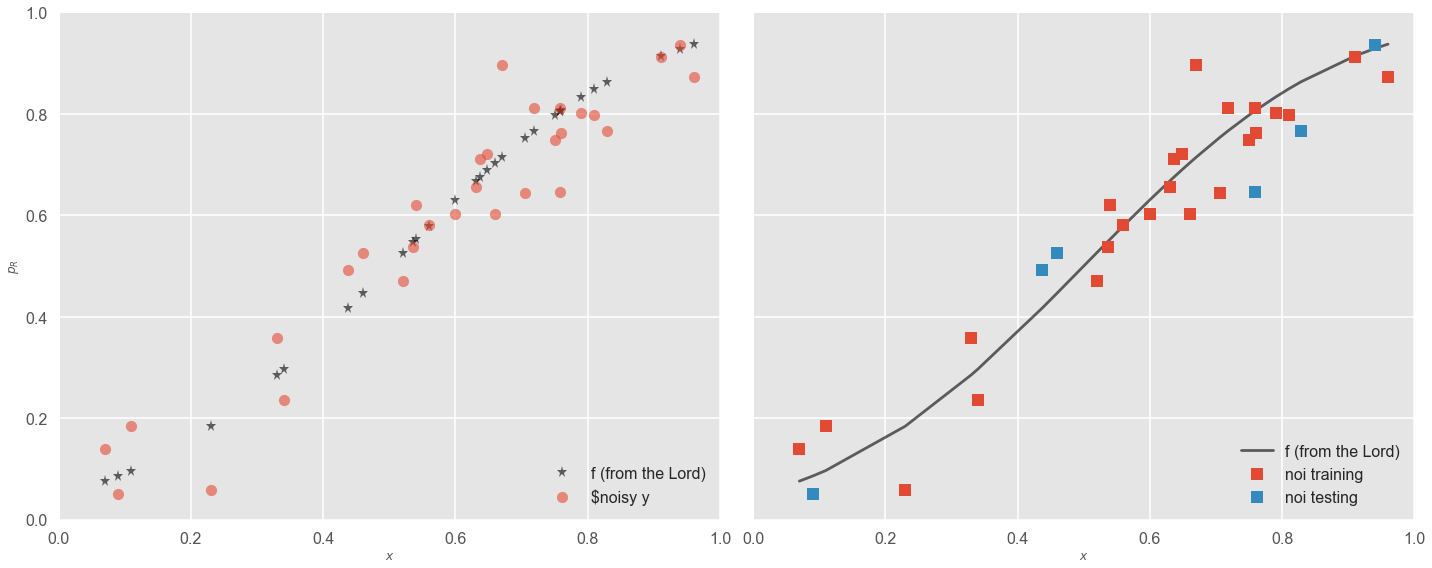

In [53]:
axes=make_plot()
axes[0].plot(df.x,df.f, 'k*', alpha=0.6, label="f (from the Lord)");
axes[0].plot(df.x,df.y, 'o',alpha=0.6, label="$noisy y");
axes[1].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[1].plot(xtrain, ytrain, 's', label="noi training")
axes[1].plot(xtest, ytest, 's', label="noi testing")
axes[0].legend(loc=4)
axes[1].legend(loc=4)


In [54]:
## use sklearn
from sklearn.preprocessing import PolynomialFeatures

## generate a 3X 5 2d array
## each row is: i^0, i^1... i^d,
## pay attension to transform shape
PolynomialFeatures(4).fit_transform([[1],[2], [3]])

def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = \
            PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = \
            PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees     =range(21)
error_train =np.empty(len(degrees))
error_test  = np.empty(len(degrees))


In [56]:
## degree 3 fit, Note that
## the input in LinearRegression().fit need
## each row of Xtrain as a sample,
## ytrain to be a 1-d array 
est3 = LinearRegression()
est3.fit(traintestlists[3]['train'], ytrain)
pred_on_train3=est3.predict(traintestlists[3]['train'])
pred_on_test3=est3.predict(traintestlists[3]['test'])

print("err train",mean_squared_error(ytrain, pred_on_train3))
print("err test ",mean_squared_error(ytest, pred_on_test3))

err train 0.036709213196386745
err test  0.11279838212264719


In [57]:
## degree 20 fit, Note that
## the input in LinearRegression().fit need
## each row of Xtrain as a sample,
## ytrain to be a 1-d array 
est20 = LinearRegression()
est20.fit(traintestlists[20]['train'], ytrain)
pred_on_train20=est20.predict(traintestlists[20]['train'])
pred_on_test20=est20.predict(traintestlists[20]['test'])

print("err train",mean_squared_error(ytrain, pred_on_train20))
print("err test ",mean_squared_error(ytest, pred_on_test20))

err train 0.002742753949091186
err test  23154707.76156648


In [58]:
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = traintestlists[d]['train']
    Xtest = traintestlists[d]['test']
    #set up model
    #fit
    #predict
    #calculate mean squared error
    #set up model
    est = LinearRegression()
    #fit
    est.fit(Xtrain, ytrain)
    #predict
    prediction_on_training = est.predict(Xtrain)
    prediction_on_test = est.predict(Xtest)
    #calculate mean squared error
    error_train[d] = mean_squared_error(ytrain, prediction_on_training)
    error_test[d] = mean_squared_error(ytest, prediction_on_test)

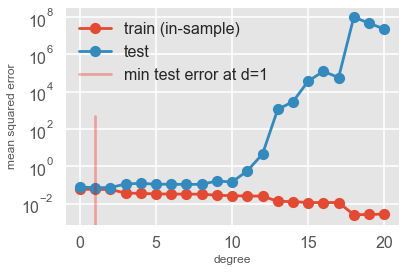

In [59]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='test')
plt.axvline(np.argmin(error_test), 0,0.5, color='r', alpha=0.3,\
            label="min test error at d=%d"%np.argmin(error_test))
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")


## Theano
it's a python lib that: define, optimize, and evaluate math expressions, especially ones with multi-dimensional arrays. Some of its advantages over other libraries (eg numpy):

1. Execution speed optimizations: Theano can use g++ / nvcc to compile parts your expression graph into CPU or GPU instructions, which run much faster than pure Python.
1. Symbolic differentiation: Theano can automatically build symbolic graphs for computing gradients. One powerful feature of Theano is that once you define symbolic variables, you can write expressions for those variables and convert these expressions into callable objects that can evaluate the expression for any value of the variables:
        Many of the types and symbols that we use are within the Theano subpackage theno.tensor.



In [26]:
import theano
from theano import *
import theano.tensor as T

# declare two symbolic floating-point scalars
a = T.dscalar('a')
b = T.dscalar('b')

# create a simple expression
c = a ** b

# convert the expression into a callable object that takes (a,b)
# values as input and computes a value for c
f = function([a,b], c)
# Behind the scenes, when you call theano.function, f is compiled into C code.

# bind 1.5 to 'a', 2.5 to 'b', and evaluate 'c'
# Note: the output is an array
f(2,1/2)

array(1.41421356)

In [32]:
# declare two symbolic floating-point matrices
x = T.matrix('x')
y = T.matrix('y')

# expression
# The product you seen is entry by entry!! Not matrix product!
z = x * y

# convert into callable
f = function([x, y], z)

# Evaluate
f([[1, 0], [0, 1]], [[10, 20], [30, 40]])


array([[10.,  0.],
       [ 0., 40.]])

There are other available Theano types, and all of them we can preform similar operations.
1. byte: bscalar, bvector, bmatrix, brow, bcol, btensor3, btensor4
1. 16-bit integers: wscalar, wvector, wmatrix, wrow, wcol, wtensor3, wtensor4
1. 32-bit integers: iscalar, ivector, imatrix, irow, icol, itensor3, itensor4
1. 64-bit integers: lscalar, lvector, lmatrix, lrow, lcol, ltensor3, ltensor4
1. nfloat: fscalar, fvector, fmatrix, frow, fcol, ftensor3, ftensor4
1. double: dscalar, dvector, dmatrix, drow, dcol, dtensor3, dtensor4
1. complex: cscalar, cvector, cmatrix, crow, ccol, ctensor3, ctensor4

### Logistic function -- sigmoid func

$$s(z) = \frac{1}{1 + e^{-z}}$$

Build a Theano graph that represents $s(z)$, ,evaluate it in a 2x2 matrix , and we can also avaluate it on a vector and plot it:

Note that: when you plug in a vector/matrix, you need the function to have [] around x

In [40]:
x = T.dmatrix('x')
s = 1 / (1 + T.exp(-x))
logistic = function([x], s)
xv = np.matrix([[0, 1], [-1, -2]])
y = logistic(xv)
y

array([[0.5       , 0.73105858],
       [0.26894142, 0.11920292]])

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gradient', 'logistic', 'dot', 'f', 'test', 'generic']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


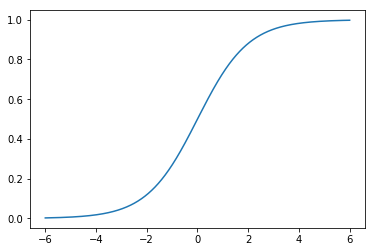

In [34]:
%pylab inline
import matplotlib.pyplot as plt

x = T.dvector('x')
s = 1 / (1 + T.exp(-x))
logistic = function([x], s)

# Build a numpy vector for the support of the function
x_eval = np.linspace(-6,6,1000)

# Evaluate the function. Note that Thenao understands numpy arrays.
y = logistic(x_eval)

# Plot
plt.plot(x_eval,y)

### Shared variables
1. Shared variables are hybrid symbolic and non-symbolic variables whose value may be shared between multiple functions.
1. symbolic -- just as the elements returned by `dvectors` or `dmatrices`. But they also adopt an internal value that defines the value the symbolic variable will have in all functions that share it.
1. shared values are useful when performing **training** in supervised learning algorithms, as we want these values to remain around across many executions of a Theano training or testing function. 
1. Often, the purpose of a Theano training function is to update the weights stored in a **shared variable**. And a testing function needs the current weights to perform the network's forward pass. 


The following is an example of how to use shared variables is by building an accumulator function.

In [64]:
from theano import shared

# We create a shared value and initiazlize it to 0.
state = shared(0)

# Define a scalar variable with the increment
inc = T.iscalar('inc')

# Everytime the function is executed, 
# our shared valuable is updated and returns old value
## the function maps inc -> state; and it also updates the state to state+inc
accumulator = function([inc], state, updates=[(state, state+inc)])

In [65]:
# Let us run it:
print(state.get_value())
print(accumulator(1))
print(state.get_value())


0
0
1


In [66]:
print(state.get_value())
print(accumulator(300))
print(state.get_value())


1
1
301


## Differentiation in Theano -- Automatic Differentiation (autdiff) for  gradients.
Autdiff is a set of techniques to numerically evaluate the derivative of a function defined by a computer program. This implies that Theano can compute the derivative of any function for which you can write code (not only for parametric functions, but also data structures). 
1. Autdiff is different from numerical differentiation (which uses finite differences) and also 
1. Autdiff is different from symbolic differentiation (which is a way to write new computer expressions for the derivative of a given function). 
1. Both numerical and symbolic differentiation can be very inefficient when calculating partial derivatives with respect to many inputs. 

Autdiffs solves for these problems.

**At the core of autdiff is the concept of dual numbers. We can extend any natural number to a dual number:**

$$x \rightarrow x + \epsilon x'$$

Just think about it as:
$$f = f+f'\Delta x;$$
$$(fg) = (f+f'\Delta x)(g+g'\Delta x) = fg+f'g'\Delta x^2+(fg'+f'g)\Delta x$$
$$=fg+(fg'+f'g)\Delta  x~,~ as~\Delta x^2 = 0$$

$\epsilon$ is just a symbol that distinguishes the second component, and we define its arithmetic as: $\epsilon^2 = 0$. With this, it is easy to see that:

$$(x + \epsilon x') + (y + \epsilon y') = x + y + \epsilon(x' + y')$$
$$(x + \epsilon x')(y + \epsilon y') = xy + \epsilon(xy' + x'y)$$
$$\frac{1}{x+\epsilon x'} =\frac{1\times(x-\epsilon x')}{(x-\epsilon x')(x+\epsilon x')} = \frac{1}{x}-\epsilon\frac{x'}{x^2}$$

We can then apply these rules to a polynomial:

$$p(x) = p_0 + p_1x + p_2x^2 + ... + p_nx^n$$

to obtain:

$$
\begin{equation}
\begin{aligned}
p(x + \epsilon x') & = p_0 + p_1(x + \epsilon x' ) + ... + p_n(x + \epsilon x')^n \\
                   & = p_0 + p_1x + p_2x^2 + ... + p_nx^n \\
                   &   \, \, \, \, + \epsilon p_1x + 2\epsilon p_2 xx' + ... + n\epsilon p_nx^{n−1}x' \\
                   & = P(x) + \epsilon P'(x)x' \\
\end{aligned}
\end{equation}
$$

We are free to choose $x' = 1$ and then **a function applied to a dual number returns its derivative in the second dual component**. Dual numbers are data structures that allow us to carry the derivatives around without too much additional computation or errors. Theano profits from autdiff to compute complicated gradients in many dimensions using `T.grad`.

### Derivative of the logistic function
We can also compute the gradient of complex expressions. It turns out that the derivative of the logistic is: $ds(x)/dx = s(x) \cdot (1 - s(x))$. But we do not even need to know its symbolic expression to evaluate it at a given point:

In [78]:
x = T.dmatrix('x')
s = T.sum(1 / (1 + T.exp(-x)))
gs = T.grad(s, x)
dlogistic = theano.function([x], gs)
dlogistic([[0, 1], [-1, -2]])

array([[0.25      , 0.19661193],
       [0.19661193, 0.10499359]])

In [79]:
g = (1 / (1 + T.exp(-x)) )*(1-1 / (1 + T.exp(-x)))
ds = function([x],g)
ds([[0, 1], [-1, -2]])

array([[0.25      , 0.19661193],
       [0.19661193, 0.10499359]])

## Gradient descent
Key aspect of training a **neural network minimizing a cost function $J(\theta)$.**
    
 
Gradient descent == updating the parameters $\theta$ in the opposite direction of the gradient of the objective function $\nabla_{\theta}J(\theta)$ w.r.t. to the parameters. 
1. you try to go down the slope in the direction where the slope is steeper. 
1. The learning rate $\eta$ is the size of the steps:

Following slop decreasing direction with step size  $\eta$ , we reach a valley.


## Classifying the Iris data set

The Iris flower data set -- multivariate data set -- describ morphological properties of three related species of the Iris flower. 

The data set consists of 50 samples from each of three species of Iris ( setosa,  virginica and  versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres.

## goal 
perform classification of this dataset using the logistic regression, and batch gradient descent to perform the minimization of the cost function (training).

### Load the dataset

The dataset is saved as a pickle file

In [90]:
import pickle
pkl_file = open('iris_dataset.pickle', 'rb')
iris_data = pickle.load(pkl_file)
features = iris_data['features']
features = np.array(features)
species = iris_data['species']
species = np.array(species)

In [94]:
## Assing numbers to species 
## (better to work with numbers than with strings)
uni = np.unique(species)

species[species == uni[0]] = 0
species[species == uni[1]] = 1
species[species == uni[2]] = 2
species = species.astype(np.int)
print(species)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [107]:
# Shuffle entries and separate into training, 
# validation and test sets:

ntotal  = len(species)
indices = np.arange(ntotal)
np.random.shuffle(indices)

species = species[indices]
features = features[indices]

nTrain = 110
nValid = 20
nFeat  = len(features[0])
train_set = [features[0:nTrain],species[0:nTrain]]
valid_set = [features[nTrain:nTrain+nValid],species[nTrain:nTrain+nValid]]
test_set = [features[nTrain+nValid:ntotal],species[nTrain+nValid:ntotal]]

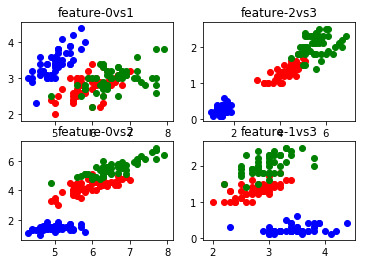

In [104]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].scatter(features[:,0][species == 0],features[:,1][species == 0],color = 'blue')
axarr[0, 0].scatter(features[:,0][species == 1],features[:,1][species == 1],color = 'red')
axarr[0, 0].scatter(features[:,0][species == 2],features[:,1][species == 2],color = 'green')
axarr[0, 0].set_title('feature-0vs1')
axarr[0, 1].scatter(features[:,2][species == 0],features[:,3][species == 0],color = 'blue')
axarr[0, 1].scatter(features[:,2][species == 1],features[:,3][species == 1],color = 'red')
axarr[0, 1].scatter(features[:,2][species == 2],features[:,3][species == 2],color = 'green')
axarr[0, 1].set_title('feature-2vs3')
axarr[1, 0].scatter(features[:,0][species == 0],features[:,2][species == 0],color = 'blue')
axarr[1, 0].scatter(features[:,0][species == 1],features[:,2][species == 1],color = 'red')
axarr[1, 0].scatter(features[:,0][species == 2],features[:,2][species == 2],color = 'green')
axarr[1, 0].set_title('feature-0vs2')
axarr[1, 1].scatter(features[:,1][species == 0],features[:,3][species == 0],color = 'blue')
axarr[1, 1].scatter(features[:,1][species == 1],features[:,3][species == 1],color = 'red')
axarr[1, 1].scatter(features[:,1][species == 2],features[:,3][species == 2],color = 'green')
axarr[1, 1].set_title('feature-1vs3')


## Using Theano to do classification with the logistic regression

We will use Theano to train a logistic regression classifier using this dataset. 

Then do validation and testing .


First, let us define symbolic variables for the features and the classes.

we have a vector of inputs (features): $\mathbf{x}$, and a vector of outputs $\mathbf{y}$. We are trying the learn a function $f$ that maps $\mathbf{x}$ into $\mathbf{y}$:

$$\mathbf{y} = f(\mathbf{w}\cdot\mathbf{x} + \mathbf{b})$$

where the matrix $\mathbf{w}$ contains the weights, and $\mathbf{b}$ is the bias vector, which are the parameters we want to optimize.

We first declare variables x, y

We then create shared variables that contain the matrix of weights and the bias terms and initialize it with normally distributed values w,b

Now we want to create computational graph that computes the cost function for using all examples in the dataset. The likelihood is is built using the softmax formulation. In this formulation, we project the input vector into a set of hyperplanes that represent the different classes, and the distance from the vector to each of these hyperplanes relates to the probability of the input belonging to a given class. Write a graph that calculates the likelihood, the loss and the cost function, as well as the gradients of the cost function with respects to the weights and the bias terms. Use an L2 regularization approach.
    > theano.tensor.nnet.nnet.softmax(x)
In the softmax formulation, the likelihood is (for this case with three classes):

$$P(\mathbf{y}|\mathbf{x};\mathbf{\theta})=
\prod_{i=1}^n\Pi_{i0}^{\mathbb{1}_0(yi)}\Pi_{i0}^{\mathbb{1}_1(yi)}\Pi_{i2}^{\mathbb{1}_2(yi)}$$

where for each training example $x_i,y_i$, $x_i$ has 4 entries from features, and $y_i = 0,1,or,2$

$$\Pi_{ij} = \frac{e^{x_i\cdot\Theta_j}}{e^{x_i\cdot\Theta_0} + e^{x_i\cdot\Theta_1} + e^{x_i\cdot\Theta_2}} $$

is the probability of the output belonging to class $j$, and $\mathbb{1}_c(y_i)$ is the indicator function, which takes the value 1 if $y_i=c$, and 0 otherwise.

If we take the *NLL* of the likelihood we get the loss function:

$$J(\theta) = -\sum_{i=1}^n\mathbb{1}_0(y_i)\log\Pi_{i0} + \mathbb{1}_1(y_i)\log\Pi_{i1}
+ \mathbb{1}_2(y_i)\log\Pi_{i2}$$

Let us code it:


In [123]:
## Declare Theano symbolic variables 
## for the features and the classes
####################################
x = T.dmatrix("x")
y = T.lvector("y")


## initialize the weight vector w randomly
## this and the following bias variable b
## are shared so they keep their values
## between training iterations (updates)
####################################

w = theano.shared(np.random.randn(nFeat,len(uni) ), \
                  name='w',borrow=True)



# initialize the bias term
b = theano.shared(value=numpy.zeros((len(uni),),\
                dtype=theano.config.floatX),\
                 name='b',borrow=True)

print("Initial model:")
print(w.get_value())
print(b.get_value())



## Construct Theano expression graph
####################################


# Probability that target belongs to class i
p_y_given_x = T.nnet.softmax(T.dot(x, w) + b)

# The prediction of the model 
#(class whose probability is maximal)
prediction = T.argmax(p_y_given_x, axis=1)      

# Loss function
loss = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])  

# The cost to minimize with regular term
cost = loss.mean() + 0.005 * (w ** 2).sum()

# Compute the gradient of the cost
gw = T.grad(cost=cost, wrt=w)

# w.r.t weight vector w and
# bias term b
# (we shall return to this in a
# following section of this tutorial)
gb = T.grad(cost=cost, wrt=b)                   
                                                
# Compile. What is a good learning rate?
eta = 0.1 # Learning rate
train = theano.function(inputs=[x,y],
          outputs=[prediction, loss],
          updates=((w, w - eta * gw), \
                   (b, b - eta * gb)),name='train')
validate = theano.function(inputs=[x,y],
          outputs=[prediction, loss],\
          name='validate')
test = theano.function(inputs=[x,y],
          outputs=[prediction, loss],\
          name='test')
predict = theano.function(inputs=[x], 
          outputs=prediction, 
        name='predict')



Initial model:
[[-0.6169571  -0.49187609 -0.41645729]
 [ 1.16529205 -0.88106563 -0.83029297]
 [ 0.21054343  0.61277569 -0.26175592]
 [-0.82244998 -0.58150502 -0.42680878]]
[0. 0. 0.]


Now train your classifier using a certain number of iteratins. Plot the evolution of the loss function for different values of the learning rate and the regularization parameter.

In [124]:
# Train
n_epochs = 50000
errors = []
errors_val = []
errors_test = []
for i in range(n_epochs):
    pred, err = train(train_set[0], train_set[1])
    errors.append(err)
    
    if (i%500 == 0):
        pred_val, err_val = validate(valid_set[0], valid_set[1])
        errors_val.append(err_val)
        
        pred_test, err_test = test(test_set[0], test_set[1])
        errors_test.append(err_test)

(-2475.0, 51975.0, 0.1117994070237964, 1.1002809924138064)

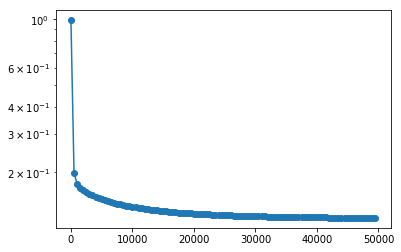

In [127]:
plt.plot(500*arange(len(errors_val)),\
         np.array(errors_val),marker='o')
plt.ylim([0,1])
plt.yscale('log')
plt.axis('tight')


# linear regression with Theano
The data set we are using is: Advertising.csv

In [10]:
# Load dataset and show the first few entries:
import pandas as pd

# read data into a DataFrame
data = pd.read_csv('Advertising.csv', index_col=0)
data.rename(columns = {'radio':'Radio','newspaper':'Newspaper','sales':'Sales'},inplace = True)
data.head()


,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


# Visualize the data 
It seems like TV-Sales is the MOST linear

Populating the interactive namespace from numpy and matplotlib


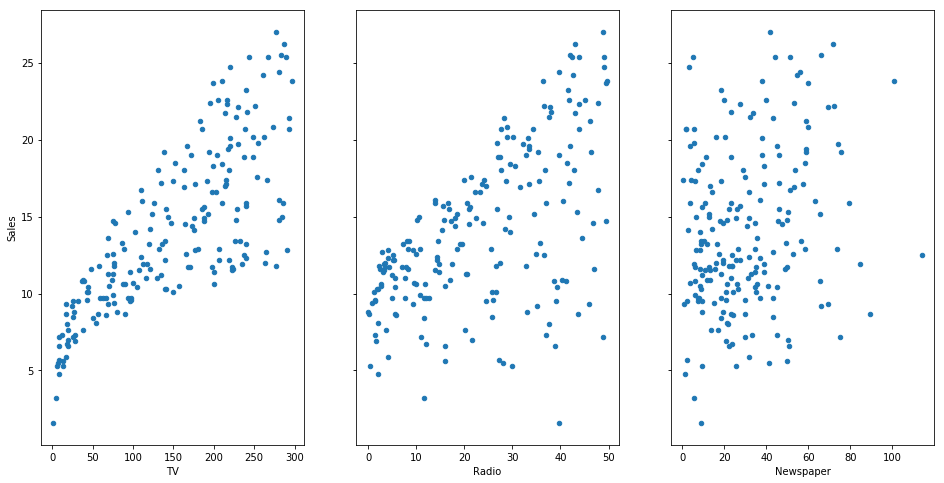

In [19]:
% pylab inline
import matplotlib.pyplot as plt
## share y-axis
## 1 row 3 columns of figures
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='TV',        y='Sales', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Radio',     y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])


In [16]:
n_examples = len(data)
n_examples


200

# linear regression in Theano:


In [21]:
import numpy as np
from theano import *
import theano.tensor as T
from theano import function
# Declare vectors for features and output:
# Declare Theano symbolic variables
ad_cost = np.asarray([data['TV'].values,\
                      data['Radio'].values,\
                      data['Newspaper'].values]).T
sales = np.asarray(data['Sales'].values)

X = T.dmatrix("X")   # Featuers
S = T.dvector("S")   # Vector of outputs (sales)


In [ ]:
# initialize the weight vector w randomly
# this and the following bias variable b
# are shared so they keep their values
# between training iterations (updates)
# We use a normal initialization
n_feats = 3 # Number of features
rng = numpy.random
#w = theano.shared(rng.randn(n_feats), name="w")
w = theano.shared(np.asarray(np.random.uniform(low = -np.sqrt(6. / (n_feats+200)), 
                                               high = np.sqrt(6. / (n_feats+200)),
                                               size = n_feats),dtype=theano.config.floatX))

# initialize the bias (intercept) term
b = theano.shared(np.asarray(0, dtype=theano.config.floatX))
# Let us print the initial model
print("Initial model:")
print(w.get_value())
print(b.get_value())
Initial model:
[-0.07802505  0.07229137 -0.16788819]
0.0
# Let us construct the Theano graph for computing the cost function
prediction = T.dot(X, w) + b  # The prediction for S, given the features X
# We have included L2 regulzarization (see below)
cost = T.sum(T.pow(prediction-S,2))/(2*n_examples)+ 0.01 * (w ** 2).sum()
#cost = T.sum(T.sqr(prediction - S)/float(n_examples))
gw = T.grad(cost=cost, wrt=w)
gb = T.grad(cost=cost, wrt=b)                   # Compute the gradient of the cost
                                                # w.r.t weight vector w and
                                                # bias term b
                                                # (we shall return to this in a
                                                # following section of this tutorial)
# And now compile the training function
eta = 5E-5
train = theano.function(
          inputs=[X,S],
          outputs=[prediction, cost],
          updates=((w, w - eta * gw), (b, b - eta * gb)),name='train')
training_steps = 1000000
# Train
loss_trace = []
for i in range(training_steps):
    pred, err = train(ad_cost, sales)
    loss_trace.append(err)
    #print(w.get_value())
print("Final model:")
print(w.get_value())
print(b.get_value())
Final model:
[ 0.04577006  0.1885331  -0.00102064]
2.9372170550890693